In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
sns.set(style="whitegrid")


In [3]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


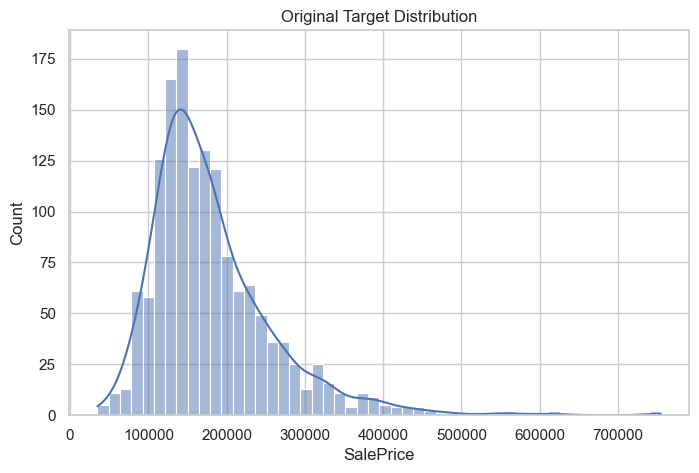

In [4]:
target = 'SalePrice'

plt.figure(figsize=(8,5))
sns.histplot(train_df[target], kde=True, bins=50)
plt.title('Original Target Distribution')
plt.show()

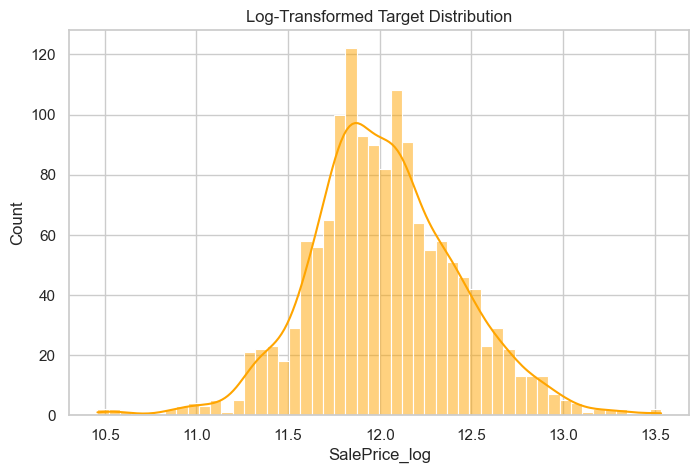

In [5]:
train_df[target+'_log'] = np.log1p(train_df[target])
plt.figure(figsize=(8,5))
sns.histplot(train_df[target+'_log'], kde=True, bins=50, color='orange')
plt.title('Log-Transformed Target Distribution')
plt.show()

Columns with missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


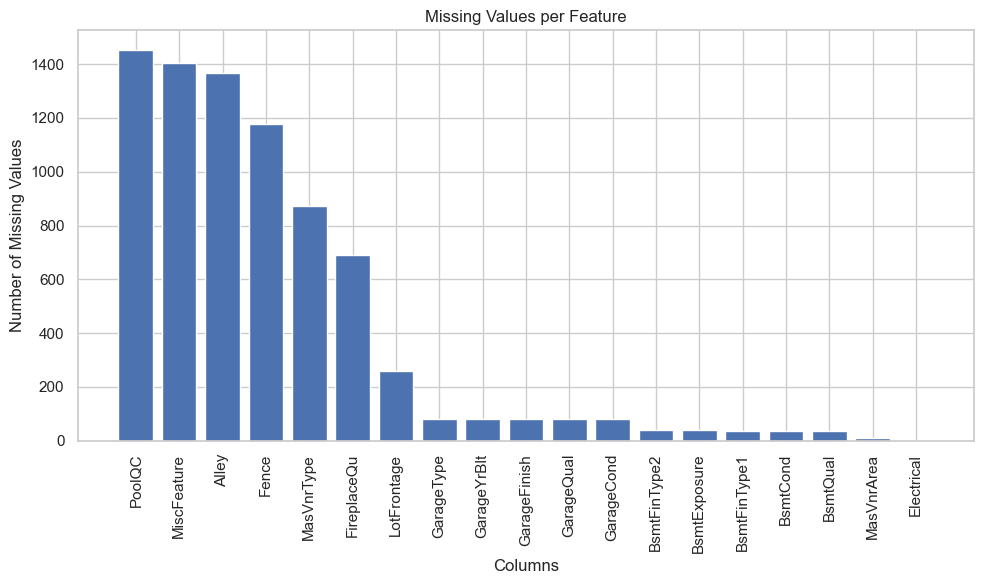

In [5]:
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)

plt.figure(figsize=(10, 6))
plt.bar(missing.index, missing.values)
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Feature")
plt.tight_layout()
plt.show()

In [6]:
def feature_engineering(df):
    # Total square footage
    if 'TotalBsmtSF' in df.columns and '1stFlrSF' in df.columns and '2ndFlrSF' in df.columns:
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # Age of house
    if 'YearBuilt' in df.columns:
        df['HouseAge'] = 2024 - df['YearBuilt']
    
    # Remodel age
    if 'YearRemodAdd' in df.columns:
        df['RemodAge'] = 2024 - df['YearRemodAdd']
    
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    
    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,TotalSF,HouseAge,RemodAge
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,208500,12.247699,2566,21,21
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,181500,12.109016,2524,48,48
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,223500,12.317171,2706,23,22
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,140000,11.849405,2473,109,54
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,250000,12.429220,3343,24,24


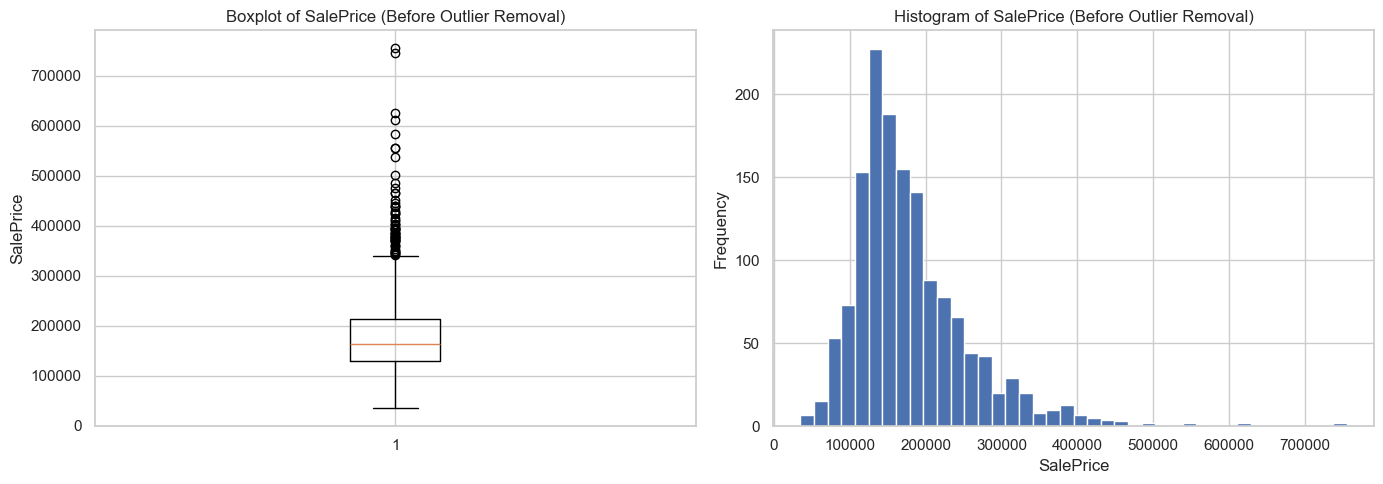

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(train_df[target])
axes[0].set_title(f"Boxplot of {target} (Before Outlier Removal)")
axes[0].set_ylabel(target)
axes[0].grid(True, axis='y')

axes[1].hist(train_df[target], bins=40)
axes[1].set_title(f"Histogram of {target} (Before Outlier Removal)")
axes[1].set_xlabel(target)
axes[1].set_ylabel("Frequency")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [7]:
Q1 = train_df[target].quantile(0.25)
Q3 = train_df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

initial_count = train_df.shape[0]
train_df = train_df[(train_df[target] >= lower) & (train_df[target] <= upper)]
removed_count = initial_count - train_df.shape[0]

print(f"Removed {removed_count} outliers from the target variable")

Removed 61 outliers from the target variable


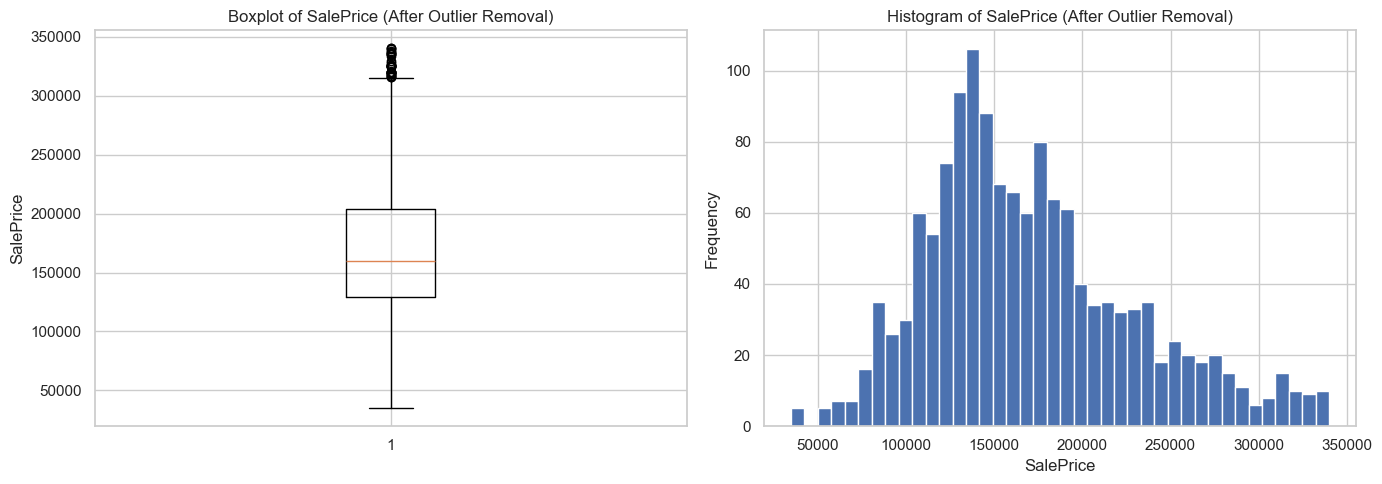

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(train_df[target])
axes[0].set_title(f"Boxplot of {target} (After Outlier Removal)")
axes[0].set_ylabel(target)
axes[0].grid(True, axis='y')

axes[1].hist(train_df[target], bins=40)
axes[1].set_title(f"Histogram of {target} (After Outlier Removal)")
axes[1].set_xlabel(target)
axes[1].set_ylabel("Frequency")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()